<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




Автор Моршинин Александр.

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>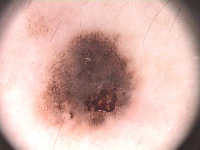</td><td>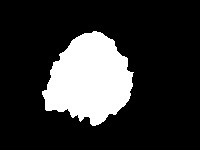</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

"wget" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
import copy

In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

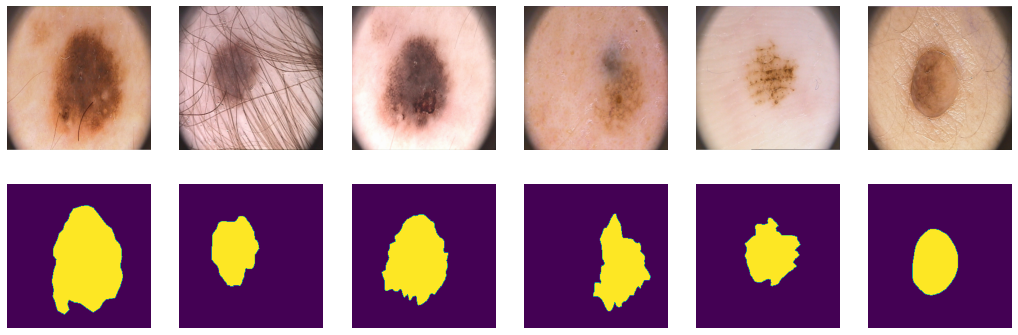

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


In [11]:
X.shape

(200, 256, 256, 3)

#### PyTorch DataLoader

In [12]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [13]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

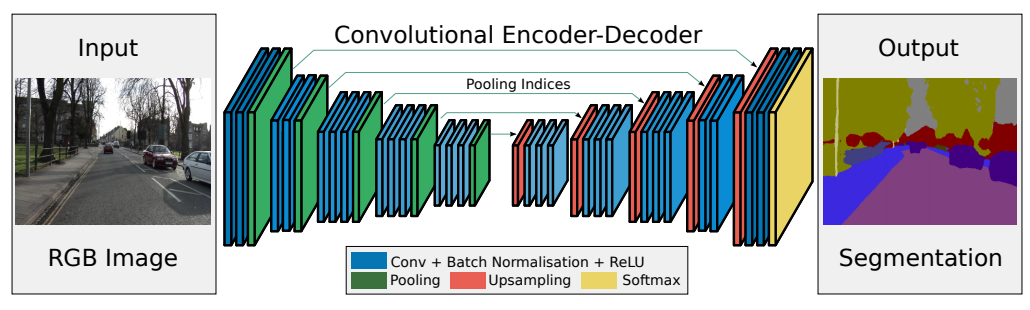

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0 = self.pool0(e0)
        
        e1 = self.enc_conv1(e0)
        e1 = self.pool1(e1)
        
        e2 = self.enc_conv2(e1)
        e2 = self.pool2(e2)
        
        e3 = self.enc_conv3(e2)
        e3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(d1)
        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(d2)
        
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(d3)
        
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_real, y_pred):
    eps = 1e-3
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    y_pred = torch.clamp(y_pred, eps, 1 - eps)
    exp = torch.clamp(1 + torch.exp(-y_pred), eps)
    return torch.mean((y_pred - y_pred * y_real + torch.log(exp)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

**Комментарий**. Будем дополнительно сохранять историю и модель, имеющую лучший скор на валидации. Можно было бы сохранять модель, имеюущую лучший лосс на валидации, но мне кажется, что правильнее сравнивать модели по метрике, а не по лоссу.

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    history = dict(train_loss=[], val_loss=[], train_score=[], val_score=[])
    
    best_model = None
    best_val_score = None
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            train_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % train_loss)
        

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_loss))
        plt.show()
        
        val_loss = 0
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            with torch.set_grad_enabled(False):
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                val_loss += loss / len(data_val)
           
        train_score = score_model(model, iou_pytorch, data_tr)
        val_score = score_model(model, iou_pytorch, data_val)
        history['train_loss'].append(train_loss.item())        
        history['val_loss'].append(val_loss.item())
        history['train_score'].append(train_score)
        history['val_score'].append(val_score)
        
        if best_val_score == None or val_score > best_val_score:
            best_val_score = val_score
            best_model = copy.deepcopy(model)    
    return history, best_model

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(probs, threshold=0.5):
    return (probs > threshold).float()

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = predict(model(X_batch))
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

# Обучаем SegNet+BCE

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


**Комментарий.** Зададим для всех моделей одинаковое кол-во эпох, дабы провести честный эксперимент.

In [21]:
max_epochs = 100

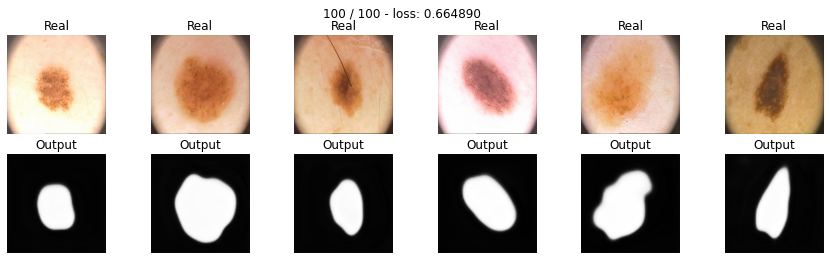

In [22]:
model_segnet_bce = SegNet().to(device)
opt = optim.Adam(model_segnet_bce.parameters())
history_segnet_bce, best_model_segnet_bce = train(model_segnet_bce, opt, bce_loss, max_epochs, data_tr, data_val)

In [23]:
score_model(best_model_segnet_bce, iou_pytorch, data_val)

0.7379999756813049

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


# Обучаем SegNet+Dice

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [24]:
def dice_loss(y_real, y_pred):
    batch_size = y_real.size(0)
    y_pred = y_pred.view(batch_size, -1)
    y_real = y_real.view(batch_size, -1)
    smooth = 1.0
    intersection = y_pred * y_real
    union = y_pred + y_real
    dice_coeff = ((2 * intersection + smooth) / (union + smooth)).sum(1)
    return 1 - 1 / (256 * 256) * torch.mean(dice_coeff)

Проводим тестирование:

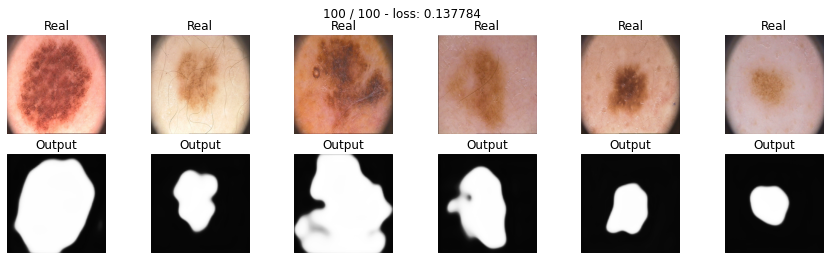

In [25]:
model_segnet_dice = SegNet().to(device)
optimaizer = optim.Adam(model_segnet_dice.parameters())
history_segnet_dice, best_model_segnet_dice = train(model_segnet_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [26]:
score_model(best_model_segnet_dice, iou_pytorch, data_val)

0.7520000040531158

# Обучаем SegNet+Focal

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [27]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    rev_pred = 1 - y_pred
    rev_real = 1 - y_real
    loss = (-(rev_pred**gamma * y_real * torch.log(torch.clamp(y_pred, min=eps)) 
              + rev_real * torch.log(torch.clamp(rev_pred, min=eps)))).mean()
    return loss

In [28]:
segnet_focal_dict = dict()

**Комментарий.** Обучим модель с разными значениями гаммы.

In [29]:
gammas = [2, 4, 6, 8]

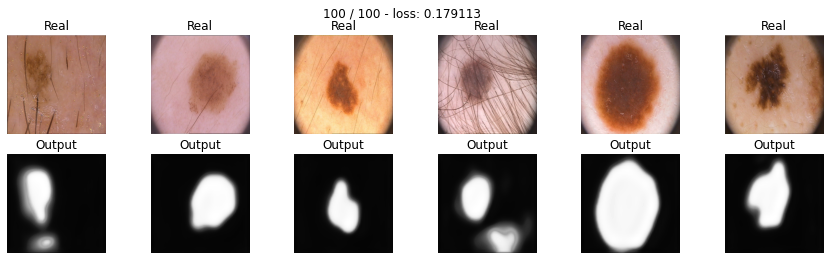

In [30]:
for gamma in gammas:
    model_segnet_focal = SegNet().to(device)
    optimaizer = optim.Adam(model_segnet_focal.parameters())
    loss = lambda x, y: focal_loss(x, y, gamma=gamma)
    segnet_focal_dict[gamma] = train(model_segnet_focal, optimaizer, loss, max_epochs, data_tr, data_val)

In [31]:
for v in segnet_focal_dict.values():
    print(score_model(v[1], iou_pytorch, data_val))

0.765999972820282
0.7420000433921814
0.7339999973773956
0.7199999690055847


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

# Обучаем SegNet+Phys

**Комментарий.** Реализована *Physiological Inspired Deep Neural Networks for Emotion Recognition*. В качестве $L_{classification}$ взята реализация *bce_loss*. В подсчете $L_{sparsity}$ нет никаких хитростей. Для подсчета $L_{contiguity}$ использовал хак, который проилюстрирован на след. примере:

посчитаем первую часть лосса $\sum|x_{i+1,j}-x_{i,j}|$ для матрицы $I = \begin{pmatrix} 1 & 2 \\ 3 &4 \end{pmatrix}$. Заметим, что нам достаточно сначала сдвинуть столбцы матрицы вправо на 1 позицию, взять срез у матрицы без первого столбца и вычесть его из $I[1:]$,  посчитав сумму элементов. Другими словами, мы получим матрицу $H = \begin{pmatrix} 2 & 1 \\ 4 & 3 \end{pmatrix}$, $I[1:] - H[1:] = \begin{pmatrix} 2 \\ 4 \end{pmatrix} - \begin{pmatrix} 1 \\ 3 \end{pmatrix} = \begin{pmatrix} 1 \\ 1 \end{pmatrix}$ и сумма равно 2. Тоже самое нужно проделать со строками.

In [51]:
def phys_loss(y_real, y_pred, lamb=1, gamma=1):
    loss_bce = bce_loss(y_real, y_pred)
    const_coeff = 1 / (256 * 256)
    y_real = torch.squeeze(y_real)
    y_pred = torch.squeeze(y_pred)
    
    loss_spars = const_coeff * torch.abs(y_pred).sum([1, 2])
    
    y_pred_h = y_pred.roll(1, dims=2)
    y_pred_v = y_pred.roll(1, dims=1)
    h_part = torch.abs(y_pred[:,:,1:] - y_pred_h[:,:,1:])
    v_part = torch.abs(y_pred[:,1:,:] - y_pred_v[:,1:,:])
    
    loss_cont = gamma * const_coeff * (h_part.sum([1, 2]) + v_part.sum([1, 2]))
                 
    loss_facial_part = torch.mean(loss_spars + loss_cont)
    
    return loss_bce + lamb * loss_facial_part
    

In [52]:
segnet_phys_dict = dict()

In [53]:
lambs = [0.1, 0.5, 1]
gammas = [0.1, 0.5, 1]

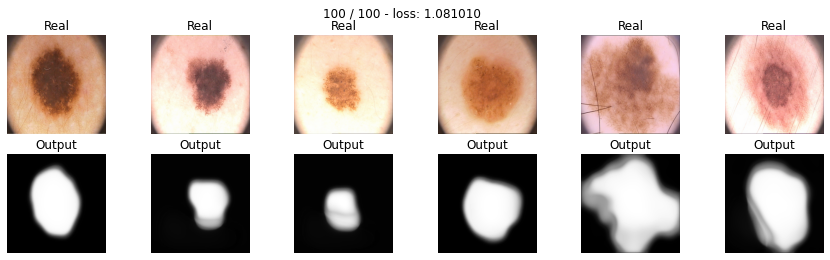

In [54]:
for lamb in lambs:
    for gamma in gammas:
        model_segnet_phys = SegNet().to(device)
        optimaizer = optim.Adam(model_segnet_phys.parameters())
        loss = lambda x, y: phys_loss(x, y, gamma=gamma, lamb=lamb)
        segnet_phys_dict[(lamb, gamma)] = train(model_segnet_phys, optimaizer, loss, max_epochs, data_tr, data_val)

In [55]:
for v in segnet_phys_dict.values():
    print(score_model(v[1], iou_pytorch, data_val))

0.7260000109672546
0.7860000133514404
0.7499999701976776
0.7620000243186951
0.7380000054836273
0.7380000352859497
0.7000000178813934
0.6800000071525574
0.7119999825954437


-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

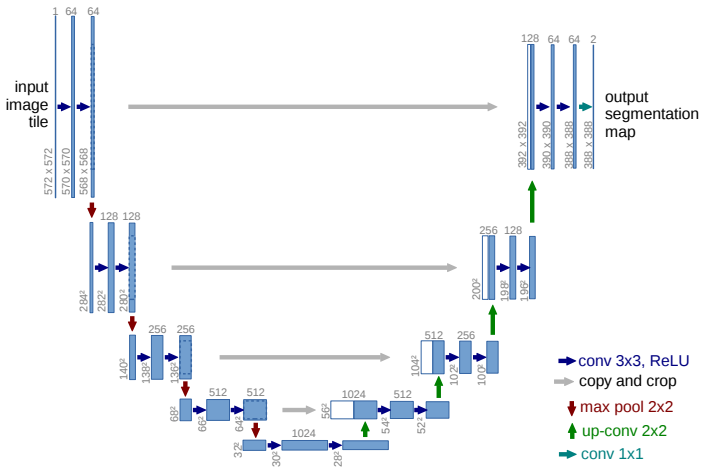

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [56]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=128*2, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64*2, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32*2, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16*2, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_up = self.pool0(e0)
        
        e1 = self.enc_conv1(e0_up)
        e1_up = self.pool1(e1)
        
        e2 = self.enc_conv2(e1_up)
        e2_up = self.pool2(e2)
        
        e3 = self.enc_conv3(e2_up)
        e3_up = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_up)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat([d0, e3], dim=1))
        
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat([d1, e2], dim=1))
        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat([d2, e1], dim=1))
        
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat([d3, e0], dim=1))
        return d3

# Обучаем UNet+BCE

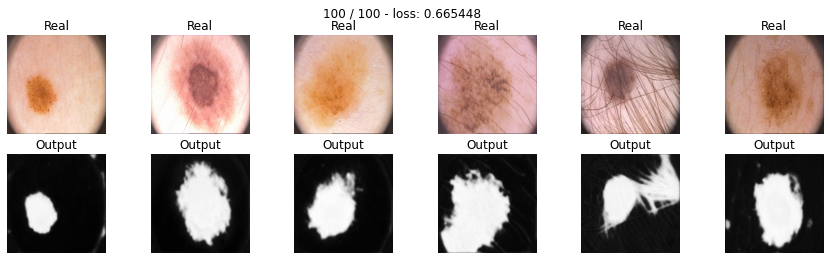

In [57]:
model_unet_bce = UNet().to(device)
optimaizer = optim.Adam(model_unet_bce.parameters())
history_unet_bce, best_model_unet_bce = train(model_unet_bce, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [58]:
score_model(best_model_unet_bce, iou_pytorch, data_val)

0.7459999620914459

# Обучаем UNet+Dice

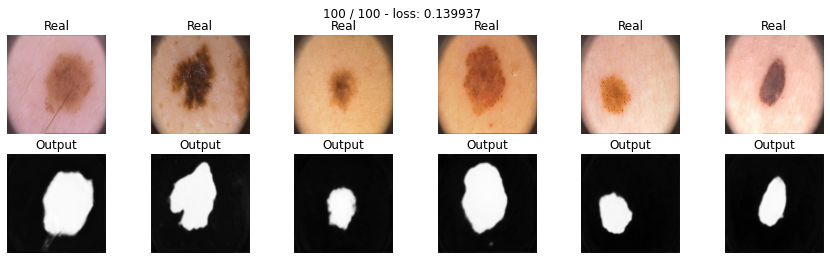

In [59]:
model_unet_dice = UNet().to(device)
optimaizer = optim.Adam(model_unet_dice.parameters())
history_unet_dice, best_model_unet_dice = train(model_unet_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [60]:
score_model(best_model_unet_dice, iou_pytorch, data_val)

0.7780000269412994

# Обучаем UNet+Focal

In [61]:
unet_focal_dict = dict()

In [62]:
gammas = [2, 4, 6, 8]

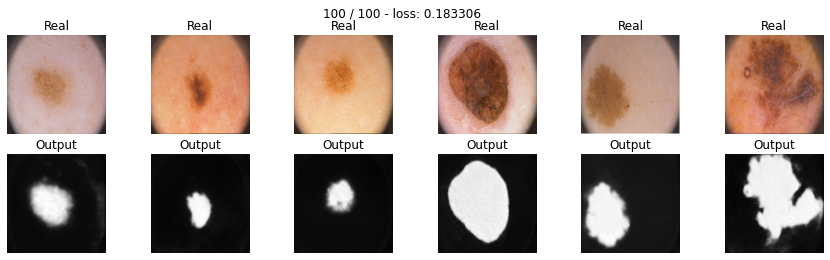

In [63]:
for gamma in gammas:
    model_unet_focal = UNet().to(device)
    optimaizer = optim.Adam(model_unet_focal.parameters())
    loss = lambda x, y: focal_loss(x, y, gamma=gamma)
    unet_focal_dict[gamma] = train(model_unet_focal, optimaizer, loss, max_epochs, data_tr, data_val)

In [64]:
for v in unet_focal_dict.values():
    print(score_model(v[1], iou_pytorch, data_val))

0.7799999415874481
0.7699999809265137
0.7280000150203705
0.7240000069141388


# Обучаем UNet+Phys

In [65]:
unet_phys_dict = dict()

In [66]:
lambs = [0.1, 0.5, 1]
gammas = [0.1, 0.5, 1]

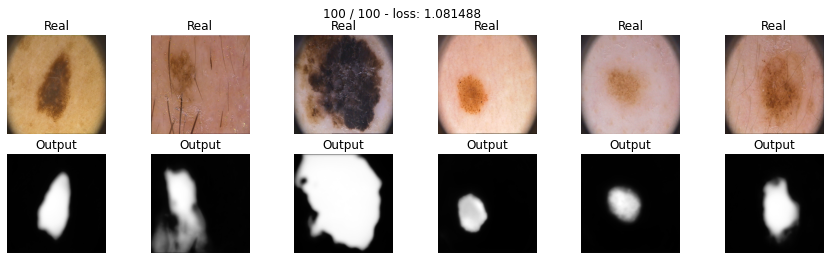

In [67]:
for lamb in lambs:
    for gamma in gammas:
        model_unet_phys = UNet().to(device)
        optimaizer = optim.Adam(model_unet_phys.parameters())
        loss = lambda x, y: phys_loss(x, y, gamma=gamma, lamb=lamb)
        unet_phys_dict[(lamb, gamma)] = train(model_unet_phys, optimaizer, loss, max_epochs, data_tr, data_val)

In [68]:
for v in unet_phys_dict.values():
    print(score_model(v[1], iou_pytorch, data_val))

0.7780000269412994
0.7640000581741333
0.7599999904632568
0.7200000286102295
0.7479999959468842
0.7380000352859497
0.707999974489212
0.7060000002384186
0.6639999449253082


Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [69]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=128*2, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64*2, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32*2, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16*2, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_up = self.pool0(e0)
        
        e1 = self.enc_conv1(e0_up)
        e1_up = self.pool1(e1)
        
        e2 = self.enc_conv2(e1_up)
        e2_up = self.pool2(e2)
        
        e3 = self.enc_conv3(e2_up)
        e3_up = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_up)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat([d0, e3], dim=1))
        
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat([d1, e2], dim=1))
        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat([d2, e1], dim=1))
        
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat([d3, e0], dim=1))
        return d3

# Обучаем UNet2+BCE

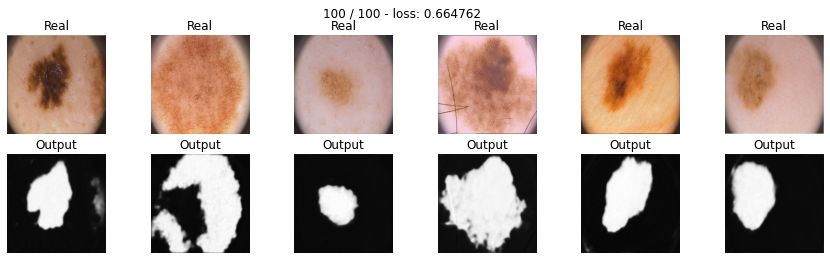

In [70]:
model_unet2_bce = UNet2().to(device)
optimaizer = optim.Adam(model_unet2_bce.parameters())
history_unet2_bce, best_model_unet2_bce = train(model_unet2_bce, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [71]:
score_model(best_model_unet2_bce, iou_pytorch, data_val)

0.7539999485015869

# Обучаем UNet2+Dice

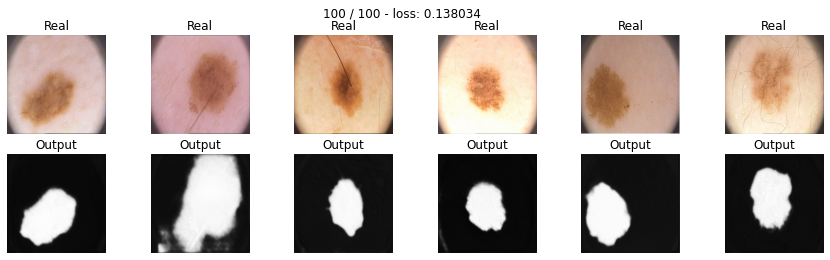

In [72]:
model_unet2_dice = UNet2().to(device)
optimaizer = optim.Adam(model_unet2_dice.parameters())
history_unet2_dice, best_model_unet2_dice = train(model_unet2_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [74]:
score_model(best_model_unet2_dice, iou_pytorch, data_val)

0.7440000176429749

# Обучаем UNet2+Focal

In [75]:
unet2_focal_dict = dict()

In [76]:
gammas = [2, 4, 6, 8]

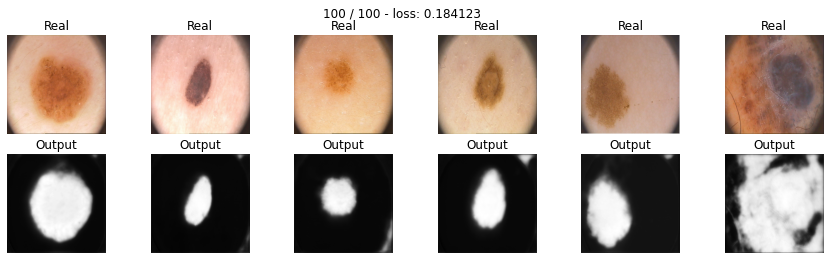

In [77]:
for gamma in gammas:
    model_unet2_focal = UNet2().to(device)
    optimaizer = optim.Adam(model_unet2_focal.parameters())
    loss = lambda x, y: focal_loss(x, y, gamma=gamma)
    unet2_focal_dict[gamma] = train(model_unet2_focal, optimaizer, loss, max_epochs, data_tr, data_val)

In [78]:
for v in unet2_focal_dict.values():
    print(score_model(v[1], iou_pytorch, data_val))

0.7799999713897705
0.7439999878406525
0.7539999485015869
0.7199999988079071


# Обучаем UNet2+Phys

In [79]:
unet2_phys_dict = dict()

In [80]:
lambs = [0.1, 0.5, 1]
gammas = [0.1, 0.5, 1]

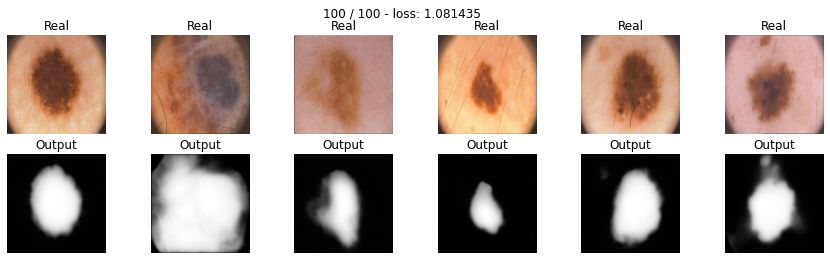

In [81]:
for lamb in lambs:
    for gamma in gammas:
        model_unet2_phys = UNet2().to(device)
        optimaizer = optim.Adam(model_unet2_phys.parameters())
        loss = lambda x, y: phys_loss(x, y, gamma=gamma, lamb=lamb)
        unet2_phys_dict[(lamb, gamma)] = train(model_unet2_phys, optimaizer, loss, max_epochs, data_tr, data_val)

In [82]:
for v in unet2_phys_dict.values():
    print(score_model(v[1], iou_pytorch, data_val))

0.7460000216960907
0.7360000014305115
0.726000040769577
0.7279999852180481
0.6940000057220459
0.699999988079071
0.6960000097751617
0.6819999814033508
0.6439999938011169


In [257]:
unet2_model = UNet2().to(device)

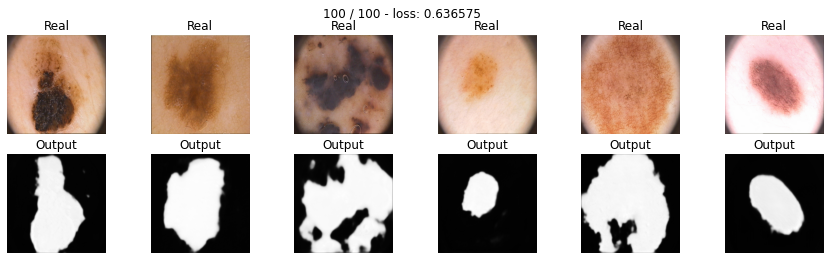

In [259]:
history, best_model = train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 100, data_tr, data_val)

In [262]:
score_model(best_model, iou_pytorch, data_val)

0.7819999754428864

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# 1. Сравнение моделей по IOU-score по отдельности

Далее будут показавать в основном графики метрики, т.к. отображение разных лоссов на 1 графике может ни о чем не говорить засчет разного масштабирования метрик. Графики лоссов приведены лишь для лоссов из одного семейства (Phys и Focal), хотя и их сравнение не является до конца корректным.

## Выбор лучшей модели для SegNet

### Выбор модели с FocalLoss

Было обучено 4 модели с параметром $\gamma \in (2, 4, 6, 8)$. Сравним качество этих моделей и выберем лучшую.

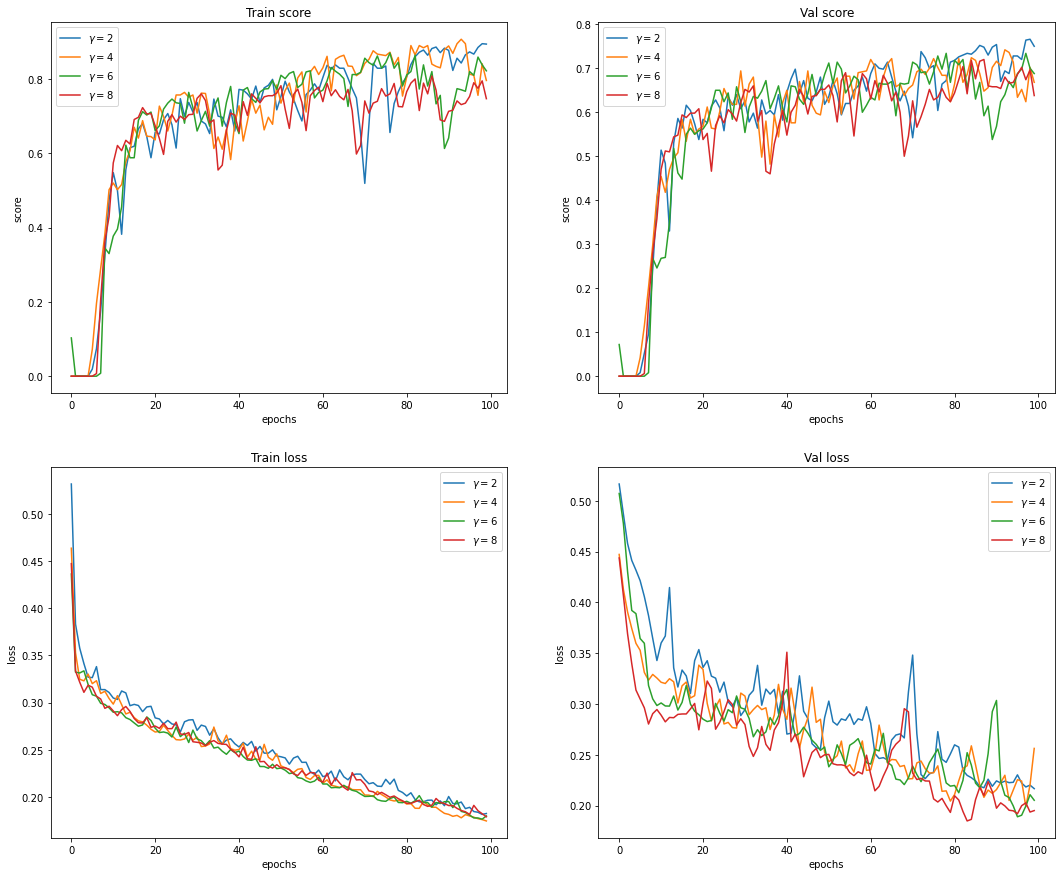

In [114]:
fig = plt.figure(figsize=(18, 15))

fig.add_subplot(2, 2, 1)
for k in segnet_focal_dict:
    train_score = segnet_focal_dict[k][0]['train_score']
    plt.plot(train_score, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(2, 2, 2)
for k in segnet_focal_dict:
    val_score = segnet_focal_dict[k][0]['val_score']
    plt.plot(val_score, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score")

fig.add_subplot(2, 2, 3)
for k in segnet_focal_dict:
    train_loss = segnet_focal_dict[k][0]['train_loss']
    plt.plot(train_loss, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train loss")

fig.add_subplot(2, 2, 4)
for k in segnet_focal_dict:
    val_loss = segnet_focal_dict[k][0]['val_loss']
    plt.plot(val_loss, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Val loss");

По графикам видно, что при всех выбранных значениях $\gamma$ модели ведут себя примерно одинаково, высшая точка val score приходятся на значение $\gamma=2$. Поскольку в процессе обучения мы сохраняли модели, доющие лучший показатель скора на валидации, дополнительно построим табличку сравнения лучшего скора валидации.

In [116]:
import pandas as pd

In [125]:
segnet_focal_df = pd.DataFrame(columns=["Gamma", "Val score"])
for k in segnet_focal_dict:
    model = segnet_focal_dict[k][1]
    score = score_model(model, iou_pytorch, data_val)
    segnet_focal_df = segnet_focal_df.append({"Gamma": k, "Val score": score}, ignore_index=True)
    
segnet_focal_df

Gamma  Val score
0    2.0      0.766
1    4.0      0.742
2    6.0      0.734
3    8.0      0.720

**Промежуточный вывод**. С ростом $\gamma$ лучший скор убывает, поэтому зафиксируем в качестве лучшей модель SegNet+Focal при $\gamma=2$.

### Выбор модели с PhysLoss

Поскольку мы обучали модель по сетке $\lambda \in (0.1, 0.5, 1)$, $\gamma \in (0.1, 0.5, 1)$, выберем лучшие параметры.

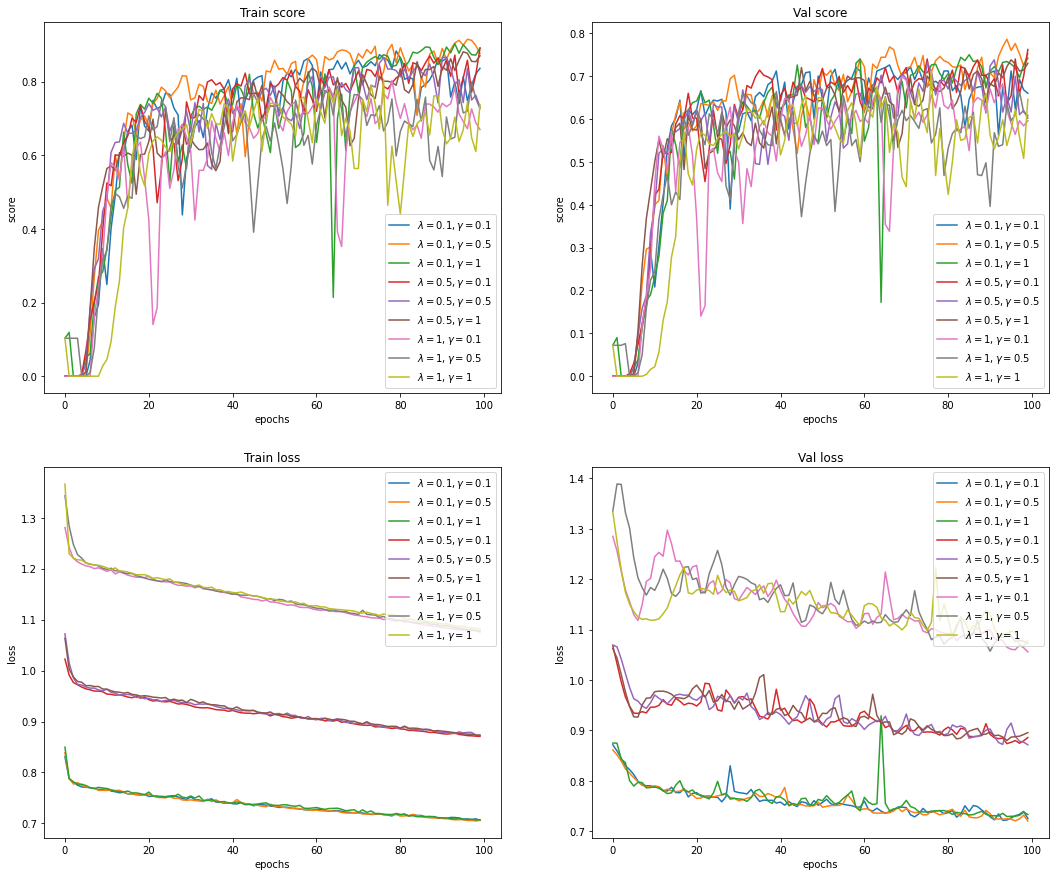

In [127]:
fig = plt.figure(figsize=(18, 15))

fig.add_subplot(2, 2, 1)
for k in segnet_phys_dict:
    train_score = segnet_phys_dict[k][0]['train_score']
    plt.plot(train_score, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(2, 2, 2)
for k in segnet_phys_dict:
    val_score = segnet_phys_dict[k][0]['val_score']
    plt.plot(val_score, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score")

fig.add_subplot(2, 2, 3)
for k in segnet_phys_dict:
    train_loss = segnet_phys_dict[k][0]['train_loss']
    plt.plot(train_loss, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train loss")

fig.add_subplot(2, 2, 4)
for k in segnet_phys_dict:
    val_loss = segnet_phys_dict[k][0]['val_loss']
    plt.plot(val_loss, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Val loss");

По графику score видно, что пик val score приходится на значения $\lambda=0.1, \gamma=0.5$. По графику лосса модели расслаиваются на 3 группы в зависимости от $\lambda$. Построим табличку.

In [134]:
segnet_phys_df = pd.DataFrame(columns=["Lambda", "Gamma", "Val score"])
for k in segnet_phys_dict:
    model = segnet_phys_dict[k][1]
    score = score_model(model, iou_pytorch, data_val)
    segnet_phys_df = segnet_phys_df.append({"Lambda": k[0], "Gamma": k[1], "Val score": score}, ignore_index=True)
segnet_phys_df

Lambda  Gamma  Val score
0     0.1    0.1      0.726
1     0.1    0.5      0.786
2     0.1    1.0      0.750
3     0.5    0.1      0.762
4     0.5    0.5      0.738
5     0.5    1.0      0.738
6     1.0    0.1      0.700
7     1.0    0.5      0.680
8     1.0    1.0      0.712

**Промежуточный вывод**. Лучший результат принадлежит модели с параметрами $\lambda=0.1, \gamma=0.5$.

### Выбираем лучшую для SegNet модель

Будем сравнивать по score, сравнивать значения loss не имеет особого смысла, т.к. фактически это разные функции, которые могут быть в разных шкалах.

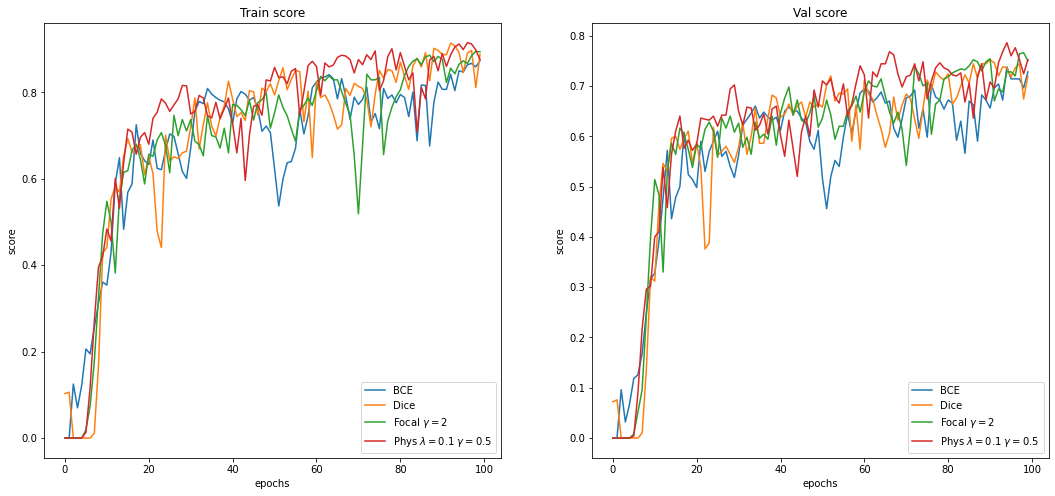

In [177]:
fig = plt.figure(figsize=(18, 8))

fig.add_subplot(1, 2, 1)
plt.plot(history_segnet_bce['train_score'], label="BCE")
plt.plot(history_segnet_dice['train_score'], label="Dice")
plt.plot(segnet_focal_dict[2][0]['train_score'], label="Focal $\gamma=2$")
plt.plot(segnet_phys_dict[(0.1, 0.5)][0]['train_score'], label="Phys $\lambda=0.1$ $\gamma=0.5$")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(1, 2, 2)
plt.plot(history_segnet_bce['val_score'], label="BCE")
plt.plot(history_segnet_dice['val_score'], label="Dice")
plt.plot(segnet_focal_dict[2][0]['val_score'], label="Focal $\gamma=2$")
plt.plot(segnet_phys_dict[(0.1, 0.5)][0]['val_score'], label="Phys $\lambda=0.1$ $\gamma=0.5$")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score");

Пик val score наблюдается для модели с PhysLoss($\lambda=0.1, \gamma=0.5$). Также построим табличку.

In [159]:
segnet_df = pd.DataFrame(columns=["Loss", "Val score"])
segnet_df = segnet_df.append({"Loss": "BCE", "Val score": score_model(best_model_segnet_bce, iou_pytorch, data_val)},
                             ignore_index=True)
segnet_df = segnet_df.append({"Loss": "Dice", "Val score": score_model(best_model_segnet_dice, iou_pytorch, data_val)},
                             ignore_index=True)
segnet_df = segnet_df.append(
    {"Loss": "Focal $\gamma=$ 2", "Val score": score_model(segnet_focal_dict[2][1], iou_pytorch, data_val)},
                             ignore_index=True)
segnet_df = segnet_df.append(
    {"Loss": "Phys $\lambda=$ 0.1, $\gamma=$ 0.5", "Val score": score_model(segnet_phys_dict[(0.1, 0.5)][1], iou_pytorch, data_val)},
                             ignore_index=True)

segnet_df

Loss  Val score
0                                 BCE      0.738
1                                Dice      0.752
2                   Focal $\gamma=$ 2      0.766
3  Phys $\lambda=$ 0.1, $\gamma=$ 0.5      0.786

**Вывод.** Выиграла модель c PhysLoss($\lambda=0.1, \gamma=0.5$). Для всех моделей наблюдается волнообразное изменение метрики с ростом эпох.

## Выбор лучшей модели для UNet

### Выбор модели с FocalLoss

Также обучено 4 модели с параметром $\gamma \in (2, 4, 6, 8)$. Сравним качество этих моделей и выберем лучшую.

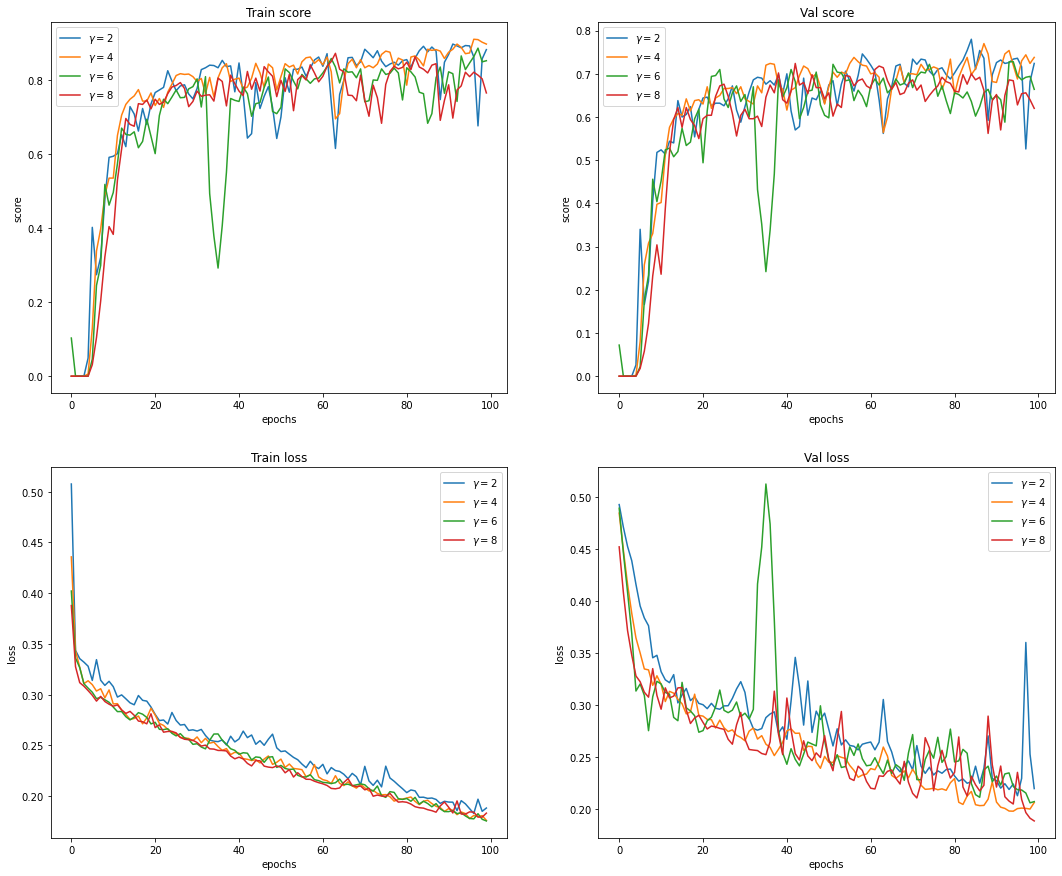

In [168]:
fig = plt.figure(figsize=(18, 15))

fig.add_subplot(2, 2, 1)
for k in unet_focal_dict:
    train_score = unet_focal_dict[k][0]['train_score']
    plt.plot(train_score, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(2, 2, 2)
for k in unet_focal_dict:
    val_score = unet_focal_dict[k][0]['val_score']
    plt.plot(val_score, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score")

fig.add_subplot(2, 2, 3)
for k in unet_focal_dict:
    train_loss = unet_focal_dict[k][0]['train_loss']
    plt.plot(train_loss, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train loss")

fig.add_subplot(2, 2, 4)
for k in unet_focal_dict:
    val_loss = unet_focal_dict[k][0]['val_loss']
    plt.plot(val_loss, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Val loss");

При $\gamma=6$ есть сильный скачок метрики, val loss сильно скачет при $\gamma=2,6$, высшая точка val score приходятся на значение $\gamma=2$.

In [116]:
import pandas as pd

In [161]:
unet_focal_df = pd.DataFrame(columns=["Gamma", "Val score"])
for k in unet_focal_dict:
    model = unet_focal_dict[k][1]
    score = score_model(model, iou_pytorch, data_val)
    unet_focal_df = unet_focal_df.append({"Gamma": k, "Val score": score}, ignore_index=True)
    
unet_focal_df

Gamma  Val score
0    2.0      0.780
1    4.0      0.770
2    6.0      0.728
3    8.0      0.724

**Промежуточный вывод**. С ростом $\gamma$ лучший скор также как и у SegNet убывает, поэтому зафиксируем в качестве лучшей модель UNet+Focal при $\gamma=2$.

### Выбор модели с PhysLoss

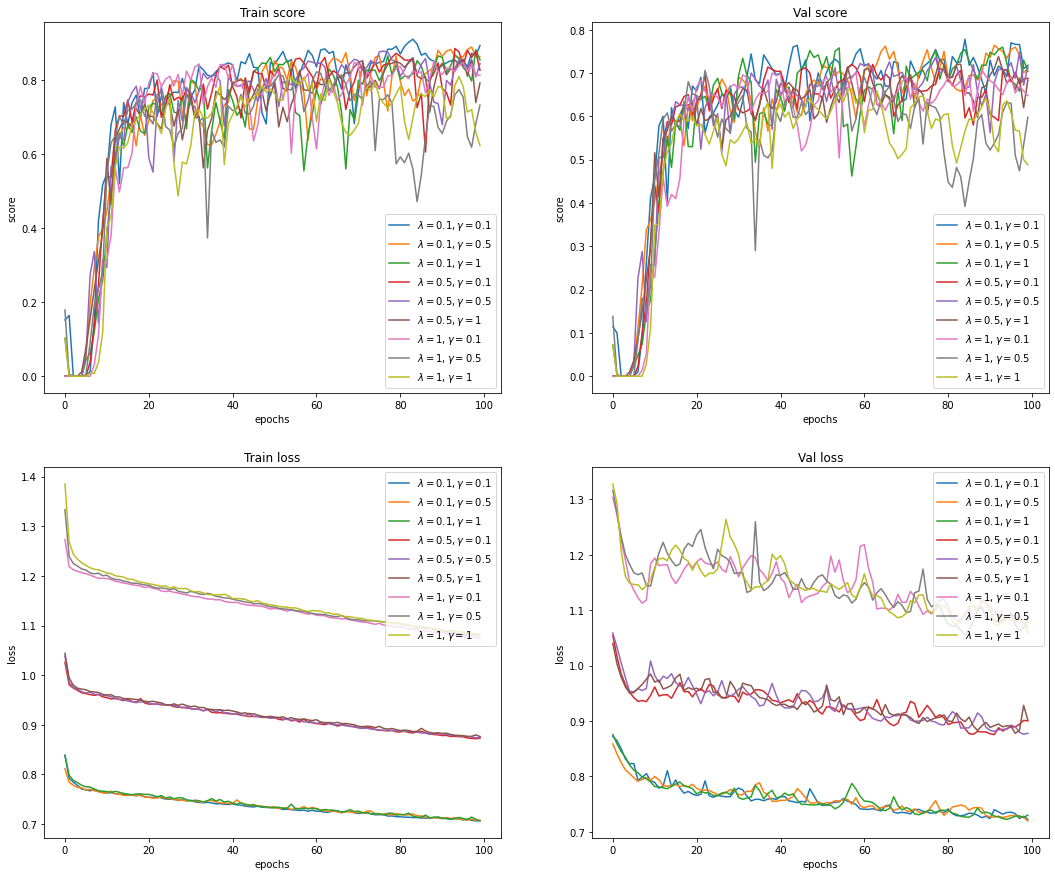

In [162]:
fig = plt.figure(figsize=(18, 15))

fig.add_subplot(2, 2, 1)
for k in unet_phys_dict:
    train_score = unet_phys_dict[k][0]['train_score']
    plt.plot(train_score, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(2, 2, 2)
for k in unet_phys_dict:
    val_score = unet_phys_dict[k][0]['val_score']
    plt.plot(val_score, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score")

fig.add_subplot(2, 2, 3)
for k in unet_phys_dict:
    train_loss = unet_phys_dict[k][0]['train_loss']
    plt.plot(train_loss, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train loss")

fig.add_subplot(2, 2, 4)
for k in unet_phys_dict:
    val_loss = unet_phys_dict[k][0]['val_loss']
    plt.plot(val_loss, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Val loss");

Скорее всего пик val loss приходится на значения $\lambda=0.1, \gamma=0.1$. Проверим их с помощью таблицы.

In [163]:
unet_phys_df = pd.DataFrame(columns=["Lambda", "Gamma", "Val score"])
for k in unet_phys_dict:
    model = unet_phys_dict[k][1]
    score = score_model(model, iou_pytorch, data_val)
    unet_phys_df = unet_phys_df.append({"Lambda": k[0], "Gamma": k[1], "Val score": score}, ignore_index=True)
unet_phys_df

Lambda  Gamma  Val score
0     0.1    0.1      0.778
1     0.1    0.5      0.764
2     0.1    1.0      0.760
3     0.5    0.1      0.720
4     0.5    0.5      0.748
5     0.5    1.0      0.738
6     1.0    0.1      0.708
7     1.0    0.5      0.706
8     1.0    1.0      0.664

**Промежуточный вывод**. Так и есть, лучший результат принадлежит модели с параметрами $\lambda=0.1, \gamma=0.1$.

### Выбираем лучшую для UNet модель

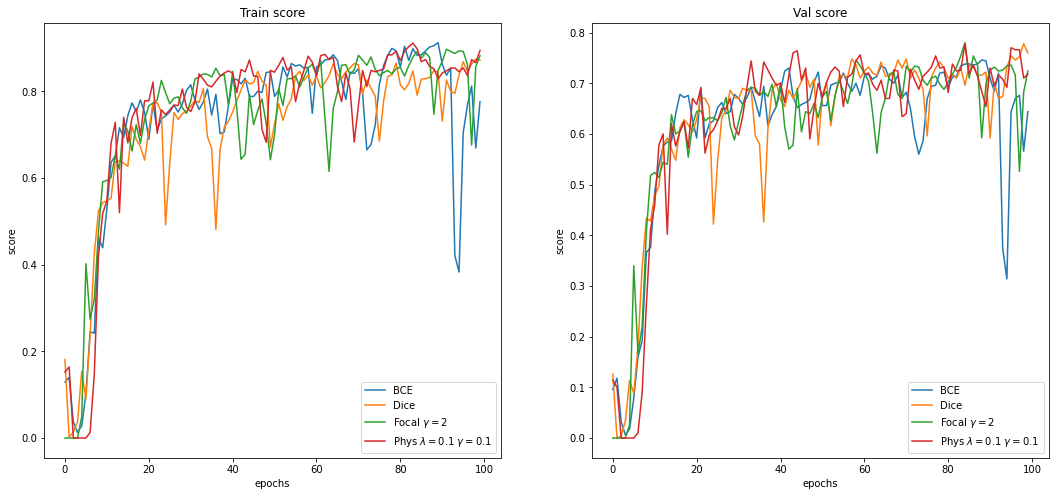

In [166]:
fig = plt.figure(figsize=(18, 8))

fig.add_subplot(1, 2, 1)
plt.plot(history_unet_bce['train_score'], label="BCE")
plt.plot(history_unet_dice['train_score'], label="Dice")
plt.plot(unet_focal_dict[2][0]['train_score'], label="Focal $\gamma=2$")
plt.plot(unet_phys_dict[(0.1, 0.1)][0]['train_score'], label="Phys $\lambda=0.1$ $\gamma=0.1$")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(1, 2, 2)
plt.plot(history_unet_bce['val_score'], label="BCE")
plt.plot(history_unet_dice['val_score'], label="Dice")
plt.plot(unet_focal_dict[2][0]['val_score'], label="Focal $\gamma=2$")
plt.plot(unet_phys_dict[(0.1, 0.1)][0]['val_score'], label="Phys $\lambda=0.1$ $\gamma=0.1$")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score");

Пик val score приходится либо на с PhysLoss($\lambda=0.1, \gamma=0.1$), либо на FocalLoss($\gamma=2$). Проверим по таблице.

In [167]:
unet_df = pd.DataFrame(columns=["Loss", "Val score"])
unet_df = unet_df.append({"Loss": "BCE", "Val score": score_model(best_model_unet_bce, iou_pytorch, data_val)},
                             ignore_index=True)
unet_df = unet_df.append({"Loss": "Dice", "Val score": score_model(best_model_unet_dice, iou_pytorch, data_val)},
                             ignore_index=True)
unet_df = unet_df.append(
    {"Loss": "Focal $\gamma=$ 2", "Val score": score_model(unet_focal_dict[2][1], iou_pytorch, data_val)},
                             ignore_index=True)
unet_df = unet_df.append(
    {"Loss": "Phys $\lambda=$ 0.1, $\gamma=$ 0.1", "Val score": score_model(unet_phys_dict[(0.1, 0.5)][1], iou_pytorch, data_val)},
                             ignore_index=True)

unet_df

Loss  Val score
0                                 BCE      0.746
1                                Dice      0.778
2                   Focal $\gamma=$ 2      0.780
3  Phys $\lambda=$ 0.1, $\gamma=$ 0.1      0.764

**Вывод.** Выиграла модель c FocalLoss($\gamma=2$).

## Выбор лучшей модели для UNet2

### Выбор модели с FocalLoss

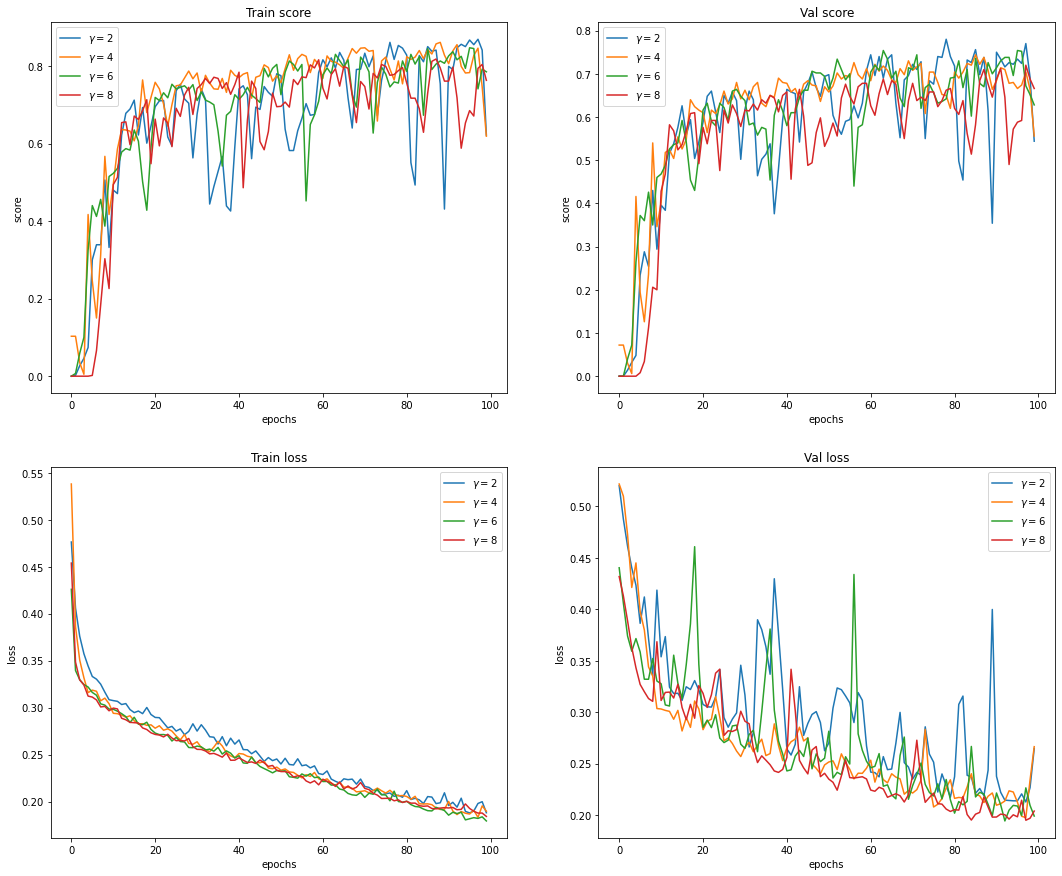

In [169]:
fig = plt.figure(figsize=(18, 15))

fig.add_subplot(2, 2, 1)
for k in unet2_focal_dict:
    train_score = unet2_focal_dict[k][0]['train_score']
    plt.plot(train_score, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(2, 2, 2)
for k in unet2_focal_dict:
    val_score = unet2_focal_dict[k][0]['val_score']
    plt.plot(val_score, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score")

fig.add_subplot(2, 2, 3)
for k in unet2_focal_dict:
    train_loss = unet2_focal_dict[k][0]['train_loss']
    plt.plot(train_loss, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train loss")

fig.add_subplot(2, 2, 4)
for k in unet2_focal_dict:
    val_loss = unet2_focal_dict[k][0]['val_loss']
    plt.plot(val_loss, label="$\gamma={}$".format(k))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Val loss");

В третий раз высшая точка val score приходятся на значение $\gamma=2$.

In [170]:
unet2_focal_df = pd.DataFrame(columns=["Gamma", "Val score"])
for k in unet2_focal_dict:
    model = unet2_focal_dict[k][1]
    score = score_model(model, iou_pytorch, data_val)
    unet2_focal_df = unet_focal_df.append({"Gamma": k, "Val score": score}, ignore_index=True)
    
unet2_focal_df

Gamma  Val score
0    2.0      0.780
1    4.0      0.770
2    6.0      0.728
3    8.0      0.724
4    8.0      0.720

**Промежуточный вывод**. С ростом $\gamma$ лучший скор также как и у SegNet и Unet убывает, поэтому зафиксируем в качестве лучшей модель UNet+Focal при $\gamma=2$.

### Выбор модели с PhysLoss

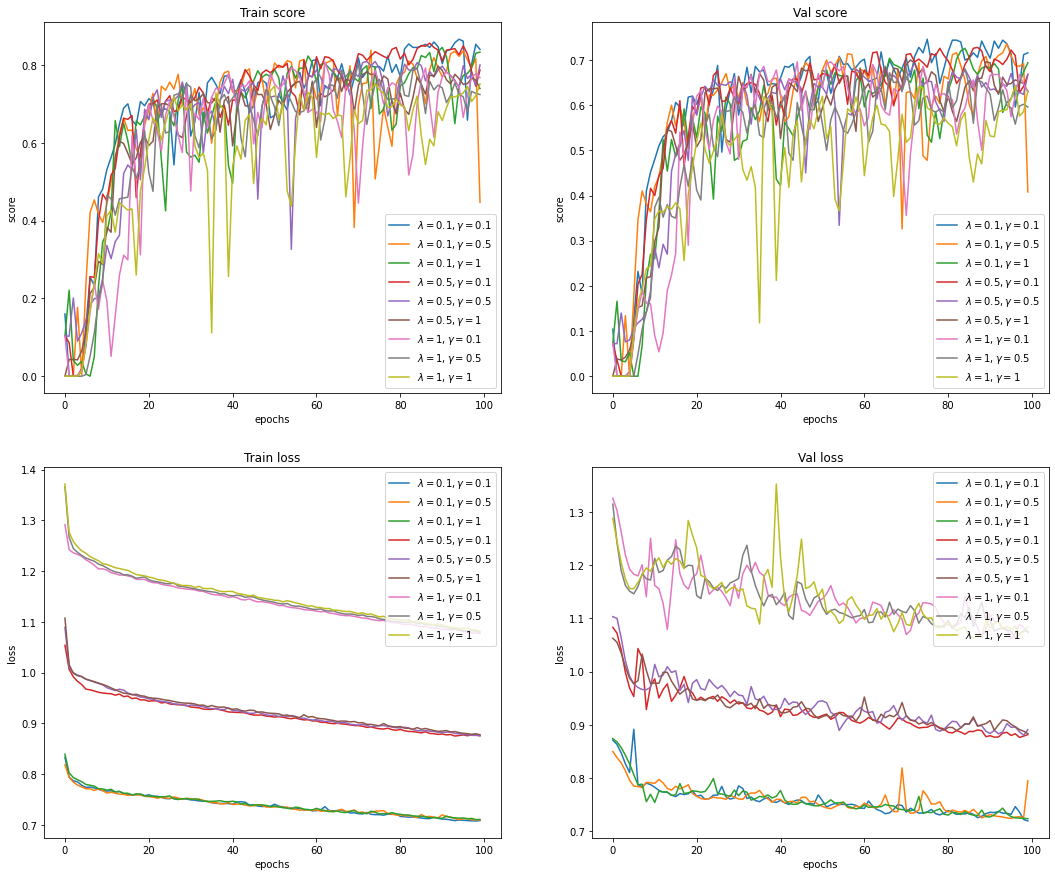

In [171]:
fig = plt.figure(figsize=(18, 15))

fig.add_subplot(2, 2, 1)
for k in unet2_phys_dict:
    train_score = unet2_phys_dict[k][0]['train_score']
    plt.plot(train_score, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(2, 2, 2)
for k in unet2_phys_dict:
    val_score = unet2_phys_dict[k][0]['val_score']
    plt.plot(val_score, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score")

fig.add_subplot(2, 2, 3)
for k in unet2_phys_dict:
    train_loss = unet2_phys_dict[k][0]['train_loss']
    plt.plot(train_loss, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train loss")

fig.add_subplot(2, 2, 4)
for k in unet2_phys_dict:
    val_loss = unet2_phys_dict[k][0]['val_loss']
    plt.plot(val_loss, label="$\lambda={}, \gamma={}$".format(k[0], k[1]))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Val loss");

Пик val loss приходится на значения $\lambda=0.1, \gamma=0.1$.

In [172]:
unet2_phys_df = pd.DataFrame(columns=["Lambda", "Gamma", "Val score"])
for k in unet2_phys_dict:
    model = unet2_phys_dict[k][1]
    score = score_model(model, iou_pytorch, data_val)
    unet2_phys_df = unet2_phys_df.append({"Lambda": k[0], "Gamma": k[1], "Val score": score}, ignore_index=True)
unet2_phys_df

Lambda  Gamma  Val score
0     0.1    0.1      0.746
1     0.1    0.5      0.736
2     0.1    1.0      0.726
3     0.5    0.1      0.728
4     0.5    0.5      0.694
5     0.5    1.0      0.700
6     1.0    0.1      0.696
7     1.0    0.5      0.682
8     1.0    1.0      0.644

**Промежуточный вывод**. Лучший результат принадлежит модели с параметрами $\lambda=0.1, \gamma=0.1$.

### Выбираем лучшую для UNet2 модель

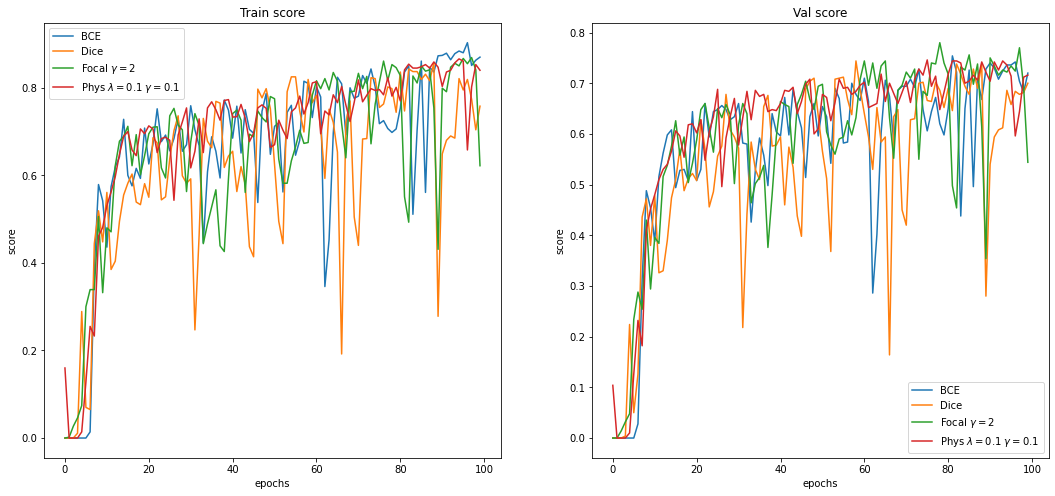

In [173]:
fig = plt.figure(figsize=(18, 8))

fig.add_subplot(1, 2, 1)
plt.plot(history_unet2_bce['train_score'], label="BCE")
plt.plot(history_unet2_dice['train_score'], label="Dice")
plt.plot(unet2_focal_dict[2][0]['train_score'], label="Focal $\gamma=2$")
plt.plot(unet2_phys_dict[(0.1, 0.1)][0]['train_score'], label="Phys $\lambda=0.1$ $\gamma=0.1$")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(1, 2, 2)
plt.plot(history_unet2_bce['val_score'], label="BCE")
plt.plot(history_unet2_dice['val_score'], label="Dice")
plt.plot(unet2_focal_dict[2][0]['val_score'], label="Focal $\gamma=2$")
plt.plot(unet2_phys_dict[(0.1, 0.1)][0]['val_score'], label="Phys $\lambda=0.1$ $\gamma=0.1$")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score");

Лучшей по val score должна быть модель FocalLoss($\gamma=2$). 

In [174]:
unet2_df = pd.DataFrame(columns=["Loss", "Val score"])
unet2_df = unet2_df.append({"Loss": "BCE", "Val score": score_model(best_model_unet2_bce, iou_pytorch, data_val)},
                             ignore_index=True)
unet2_df = unet2_df.append({"Loss": "Dice", "Val score": score_model(best_model_unet2_dice, iou_pytorch, data_val)},
                             ignore_index=True)
unet2_df = unet2_df.append(
    {"Loss": "Focal $\gamma=$ 2", "Val score": score_model(unet2_focal_dict[2][1], iou_pytorch, data_val)},
                             ignore_index=True)
unet2_df = unet2_df.append(
    {"Loss": "Phys $\lambda=$ 0.1, $\gamma=$ 0.1", "Val score": score_model(unet2_phys_dict[(0.1, 0.5)][1], iou_pytorch, data_val)},
                             ignore_index=True)

unet2_df

Loss  Val score
0                                 BCE      0.754
1                                Dice      0.744
2                   Focal $\gamma=$ 2      0.780
3  Phys $\lambda=$ 0.1, $\gamma=$ 0.1      0.736

**Вывод.** Выиграла модель c FocalLoss($\gamma=2$).

# 2. Выбор итоговой лучшей модели

От Segnet, Unet и Unet2 мы имеем по лучшей модели. Сравним эти 3 модели.

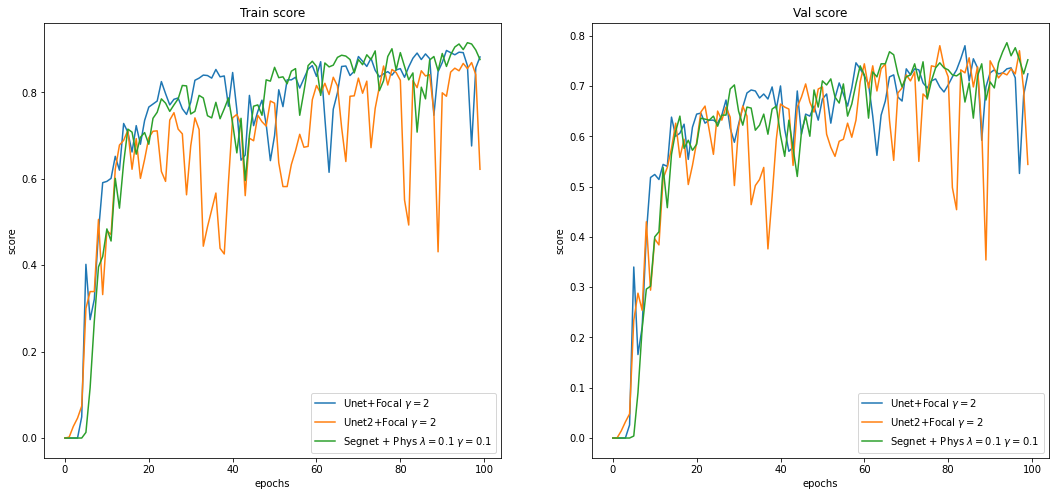

In [175]:
fig = plt.figure(figsize=(18, 8))

fig.add_subplot(1, 2, 1)
plt.plot(unet_focal_dict[2][0]['train_score'], label="Unet+Focal $\gamma=2$")
plt.plot(unet2_focal_dict[2][0]['train_score'], label="Unet2+Focal $\gamma=2$")
plt.plot(segnet_phys_dict[(0.1, 0.5)][0]['train_score'], label="Segnet + Phys $\lambda=0.1$ $\gamma=0.1$")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Train score")

fig.add_subplot(1, 2, 2)
plt.plot(unet_focal_dict[2][0]['val_score'], label="Unet+Focal $\gamma=2$")
plt.plot(unet2_focal_dict[2][0]['val_score'], label="Unet2+Focal $\gamma=2$")
plt.plot(segnet_phys_dict[(0.1, 0.5)][0]['val_score'], label="Segnet + Phys $\lambda=0.1$ $\gamma=0.1$")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.title("Val score");

По графику видно, что пики val score всех 3 моделей очень близки. Сравним их в табличном виде.

In [178]:
final_df = pd.DataFrame(columns=["Loss", "Val score"])
final_df = final_df.append(
    {"Loss": "Unet2+Focal $\gamma=$ 2", "Val score": score_model(unet2_focal_dict[2][1], iou_pytorch, data_val)},
                             ignore_index=True)
final_df = final_df.append(
    {"Loss": "Unet+Focal $\gamma=$ 2", "Val score": score_model(unet_focal_dict[2][1], iou_pytorch, data_val)},
                             ignore_index=True)

final_df = final_df.append(
    {"Loss": "SegNet+Phys $\lambda=$ 0.1, $\gamma=$ 0.5", "Val score": score_model(segnet_phys_dict[(0.1, 0.5)][1], iou_pytorch, data_val)},
                             ignore_index=True)

final_df

Loss  Val score
0                    Unet2+Focal $\gamma=$ 2      0.780
1                     Unet+Focal $\gamma=$ 2      0.780
2  SegNet+Phys $\lambda=$ 0.1, $\gamma=$ 0.5      0.786

# Вывод

Итак, было реализовано 3 архитектуры с различными лоссами. Самой интересной выглядели архитектуры Unet и Unet2 засчет присутствия skip-connection. Ожидалось, что какая-то из этих архитектура станет лучшей в связке с PhysLoss (как самый интересный и нетривиальный). 

Однако, лучшей стала модель SegNet+PhysLoss( $\lambda=0.1$ ,  $\gamma=0.5$ ), немного опередив две другие модели. Самым стабильным лоссом стал Focal( $\gamma=2$ ), который был лучшим для 2 из 3 моделей и стабильно входил в топ. PhysLoss также показал себя хорошо, чуть-чуть проиграв Focal для Unet. Самой стабильной была архитектура Unet, которая имела хорошие значения метрики для всех лоссов, а самой нестабильной можно назвать Unet2. В целом, как видно из окончательных значений метрики, все 3 модели справляются неплохо с задачей при подборе необходимой loss-функции и параметров.